# TD1 - KPPV et réseaux de neurones pour la classification d'images

**Paul Flagel - Nathan Etourneau**

L'objectif de ce TP est d'implémenter un classifieur d'images au moyen de deux méthodes : les K Plus Proches Voisins (KPPV) et un réseau de neurones.

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# 0. Dataset utilisé pour la classification

Nous utiliserons la base d'images CIFAR-10 (https://www.cs.toronto.edu/~kriz/cifar.html) constituée de 60 000 images en couleur de taille 32x32 pixels, réparties en 10 classes (avion, voiture, oiseau, chat...). Le fichier est constitué de 5 batchs de 10000 images, et d'un batch de test de 10000 images.

Nous implémentons les fonctions nécessaires à leur extraction

In [15]:
path = "./cifar-10-python/cifar-10-batches-py"

def unpickle(file):
    import pickle

    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict
    # Clés : [b'batch_label', b'labels', b'data', b'filenames']
    

def lecture_cifar(path: str, nb_batches):
    X = np.zeros(((nb_batches + 1) * 10000, 3072))
    Y = np.zeros(((nb_batches + 1) * 10000))
    for i in range(1, nb_batches + 1):
        batch_path = f"{path}/data_batch_{str(i)}"
        new_dict = unpickle(batch_path)
        batch_array = new_dict[b"data"]
        batch_labels = new_dict[b"labels"]
        X[(i - 1) * 10000 : i * 10000, :] = batch_array
        Y[(i - 1) * 10000 : i * 10000] = batch_labels

    new_dict = unpickle(f"{path}/test_batch")
    batch_array = new_dict[b"data"]
    batch_labels = new_dict[b"labels"]
    X[nb_batches * 10000 : (nb_batches + 1) * 10000, :] = batch_array
    Y[nb_batches * 10000 : (nb_batches + 1) * 10000] = batch_labels

    X = np.float32(X)
    Y = Y.astype(int)

    return X, Y

Ici, nous avons extrait les images dans des vecteurs de taille M = 32x32x3 = 3072, et nous les avons placées dans une matrice X de taille NxM avec N = 60 000. Nous retournons également un vecteur Y de taille Nx1 contenant le label de la classe de chaque image.

Nous implémentons maintenant une fonction permettant de découper les données en un set d'entraînement et un set de test. Nous avons la possibilité de choisir le ratio `taille_entrainement/taille_totale` et le booléen `small_sample` peut être passé à `True` pour ne prendre qu'un sous ensemble des images totales (permettant de prototyper plus rapidement les algorithmes).

In [16]:
def decoupage_donnees(X, Y, ratio=0.8, small_sample=False):
    N = X.shape[0]
    indices = np.array(range(N))
    np.random.shuffle(indices)

    if small_sample:
        X_train = X[indices[:500], :]
        Y_train = Y[indices[:500]]

        X_test = X[indices[-100:], :]
        Y_test = Y[indices[-100:]]

        return X_train, Y_train, X_test, Y_test

    M = int(ratio * N)
    X_train = X[indices[:M], :]
    Y_train = Y[indices[:M]]

    X_test = X[indices[M:], :]
    Y_test = Y[indices[M:]]

    return X_train, Y_train, X_test, Y_test

Nous extrayons les images et nous les découpons en allouant 80% des images à l'entrainement et 20% au test.

In [17]:
label_dict = unpickle(f"{path}/batches.meta")
label_names = label_dict[b"label_names"]

X, Y = lecture_cifar(path=path, nb_batches=5)
X_train, Y_train, X_test, Y_test = decoupage_donnees(
    X, Y, ratio=0.8, small_sample=True
)

print(f"LABELS : {label_names}")
print(f"Dim X : {X.shape}")
print(f"Dim Y : {Y.shape}")

LABELS : [b'airplane', b'automobile', b'bird', b'cat', b'deer', b'dog', b'frog', b'horse', b'ship', b'truck']
Dim X : (60000, 3072)
Dim Y : (60000,)


**Visualisation des images**

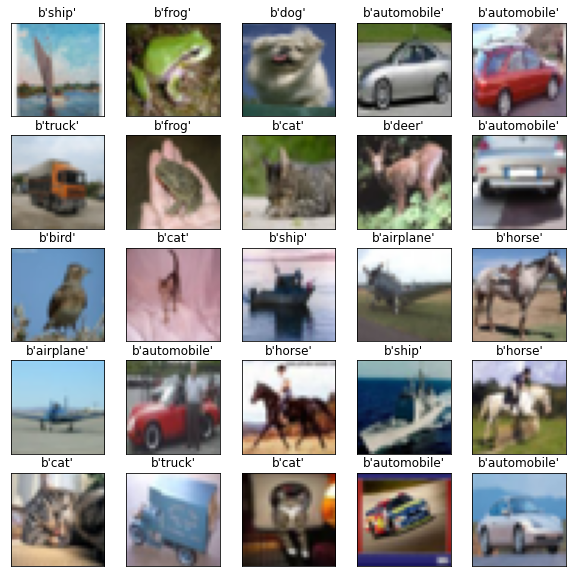

In [27]:
data_batch_1 = unpickle(f"{path}/data_batch_1")
images = data_batch_1[b'data']
images = images.reshape(len(images),3,32,32).transpose(0,2,3,1)

rows, columns = 5, 5
imageId = np.random.randint(0, len(images), rows * columns)
images = images[imageId]
labels = [data_batch_1[b'labels'][i] for i in imageId]

# define figure
fig=plt.figure(figsize=(10, 10))
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.title("{}"
          .format(label_names[labels[i-1]]))
plt.show()

# 1. KPPV